In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
from matplotlib          import rcParams
from scipy.integrate     import odeint
from scipy.optimize      import basinhopping

plt.close('all')
sns.set_context('notebook')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor']   = 'white'


## Define the Model

In [2]:
def model(y, t, params):
    mRNA = y[0]
    prot = y[1]
    
    inducer = params[0]
    synm    = params[1]  
    k_ind   = params[2] 
    degm    = params[3] 
    synp    = params[4]
    mu      = params[5]
    
    dmRNA = synm*(inducer)/(inducer+k_ind)-degm*mRNA
    dprot = synp*mRNA-mu*prot
    
    return np.array([dmRNA, dprot])

## Plot Data

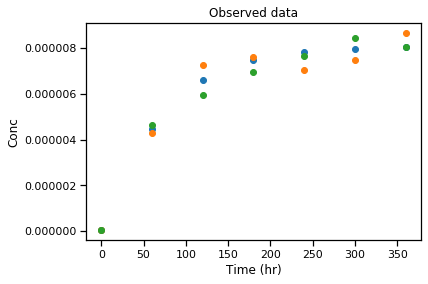

In [3]:
#Part 1: Produce a data set (evidence) and plot it
raw_data = pd.read_csv("Example_Data.csv")
tspan    = raw_data.iloc[:,0]
y_data   = raw_data.iloc[:,1:]

fig1 = plt.figure()
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(tspan, y_data,'o')
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')



## Integrating the Model

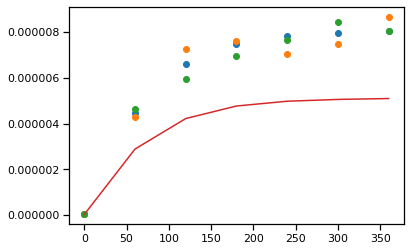

In [4]:
# Part 2: Integrate model using a set of parameters

y_init  = [0, 2.5e-8]
values  = {'inducer' : 1,
           'synm1'   : 2e-5,  
           'k_ind'   : 12, 
           'degm'    : 0.2,  
           'synp'    : 0.01,
           'mu'      : 0.015
          }
params     = list(values.values())
tspan= [0, 60, 120, 180, 240, 300, 360]
model_data = odeint(model, y_init, tspan, args=tuple([params]))
y_model    = model_data[:,1]

fig2 = plt.figure()
ax2  = fig2.add_subplot(1,1,1)
ax2.plot(tspan, y_data,'o')
ax2.plot(tspan, y_model)
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

## Calculating Sum Squared Error

In [5]:
#Part 3: Calculate error

SSE = 0
for column in y_data:
    SSE += np.sum((y_data[column]-y_model)**2)

print(SSE)

1.210589965016378e-10


## Wrap Process into a Function

In [6]:
def get_SSE(tspan, y_data, params):
    model_data = odeint(model, y_init, tspan, args=tuple([params]))
    y_model    = model_data[:,1]
    
    SSE = 0
    for column in y_data:
        SSE += np.sum((y_data[column]-y_model)**2)
    
    return SSE
    

In [7]:
print(get_SSE(tspan, y_data, params))

1.210589965016378e-10


## Optimization Function

We will be using scipy's basinhopping algorithm for this problem, which seeks the minimum of an objective function. Since our goal is to minimize the SSE, our objective function is simply get_SSE. However, the documentation of the algorithm only allows the objective function to take in one argument. In addition, we already know the inducer concentration so we want it to be fixed. We thus wrap get_SSE as shown below. 

In [8]:
def objective_function_wrapper(tspan, y_data, inducer):
    def helper(params):
        #Inducer concentration is fixed at 1.
        params_ = [1] + list(params)
        return get_SSE(tspan, y_data, params)
    return helper

In [9]:
#Wrap get_SSE
objective_function = objective_function_wrapper(tspan, y_data, params[0])
#This function now takes in the params as the sole argument and returns the SSE.

#Run optimizer.
x0     = list(params)[1:] #Remember not to include the inducer!
result = basinhopping(objective_function, x0=params, niter=100, disp=True)
best_value  = result.fun
best_params = result.x
print(result)

basinhopping step 0: f 2.72187e-12
basinhopping step 1: f 3.17656e-11 trial_f 3.17656e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 2: f 3.07992e-11 trial_f 3.07992e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 3: f 3.10216e-11 trial_f 3.10216e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 4: f 1.78495e-09 trial_f 1.78495e-09 accepted 1  lowest_f 2.72187e-12
basinhopping step 5: f 4.94979e-11 trial_f 4.94979e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 6: f 2.9636e-08 trial_f 2.9636e-08 accepted 1  lowest_f 2.72187e-12
basinhopping step 7: f 8.46941e-10 trial_f 8.46941e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 8: f 5.32588e-10 trial_f 5.32588e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 9: f 1.15642e-09 trial_f 1.15642e-09 accepted 1  lowest_f 2.72187e-12
basinhopping step 10: f 1.76034e-07 trial_f 1.76034e-07 accepted 1  lowest_f 2.72187e-12
basinhopping step 11: f 9.43885e-09 trial_f 9.43885e-09 accepted 1  lowest_f 2.72187e-

basinhopping step 93: f 5.37484e-09 trial_f 5.37484e-09 accepted 1  lowest_f 2.72187e-12
basinhopping step 94: f 9.65924e-10 trial_f 9.65924e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 95: f 6.15192e-07 trial_f 6.15192e-07 accepted 1  lowest_f 2.72187e-12
basinhopping step 96: f 1.07297e-08 trial_f 1.07297e-08 accepted 1  lowest_f 2.72187e-12
basinhopping step 97: f 3.0567e-08 trial_f 3.0567e-08 accepted 1  lowest_f 2.72187e-12
basinhopping step 98: f 3.88002e-08 trial_f 3.88002e-08 accepted 1  lowest_f 2.72187e-12
basinhopping step 99: f 5.59248e-08 trial_f 5.59248e-08 accepted 1  lowest_f 2.72187e-12
adaptive stepsize: acceptance rate 0.990000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 7.72412e-07 trial_f 7.72412e-07 accepted 1  lowest_f 2.72187e-12
                        fun: 2.7218665275270594e-12
 lowest_optimization_result:       fun: 2.7218665275270594e-12
 hess_inv: array([[ 9.99999999e-01, -2.40354250e-05,  7.89109738e-11,


## Check the Result

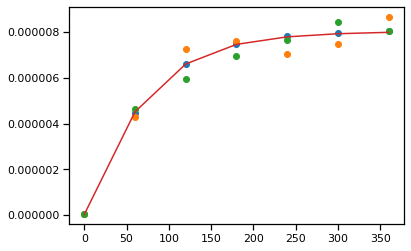

In [10]:
model_data = odeint(model, y_init, tspan, args=tuple([best_params]))
y_model    = model_data[:,1]

fig3 = plt.figure()
ax3  = fig3.add_subplot(1,1,1)
ax3.plot(tspan, y_data,'o')
ax3.plot(tspan, y_model)
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

In [11]:
#True parameter values
answer = {'inducer' : 1,
           'vmax1'   : 1e-5,  
           'km1'     : 10, 
           'deg1'    : 0.15,  
           'vmax2'   : 0.02,
           'mu'      : 0.015
          }

## Assignment


1. Use a different model. 
    - Suppose we want to simplify the model into a one-step process i.e. protein synthesis is directly controlled by the inducer with no mRNA involved. Write your own model function and repeat the steps above using your model.
    - Suppose we want to model gene expression as a two-step process plus one maturation step i.e. protein synthesis is followed by a first order maturation step. Write your own model function and repeat the steps above using your model.

2. Use a different optimizer.
    - Suppose we want to use differential evolution for curve-fitting. Repeat the steps above using scipy's differential evolution optimizer.
    - Suppose we want to use dual annealing for curve-fitting. Repeat the steps above using scipy's dual annealing optimizer.

3. Test your understanding
    - Why do we use sum squared error instead of simply summing up the errors directly?
    - Suppose we use an optimizer that searches for the maximum value of an objective function. Do we need to change the objective function? If so, how should we change it?

4. Analyze the results
    - The true parameters used to generate the data are shown in the cell above. Does your simulations always converge to the true parameters? Why? What are the underlying factors? How can we ensure that we can determine the true parameters? Does it always matter if we cannot determine the true parameters? (1000 words)